In [59]:
# Import modules
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from minisom import MiniSom
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve

In [60]:
# Constants
DATA_PATH = "/users/mik2002/som/dataset-processed/"
FILES = ["processed_bot_dataset.csv", "processed_dos_dataset.csv", "processed_bruteforce_dataset.csv"]

In [61]:
df_dataset = pd.concat([pd.read_csv(DATA_PATH + file) for file in FILES],ignore_index=True)

In [62]:
display(df_dataset["Label"].value_counts())
print("Distribution:")
display(df_dataset["Label"].value_counts(normalize=True))

Label
Benign        2858495
Dos            507715
Bot            282310
Bruteforce     156668
Name: count, dtype: int64

Distribution:


Label
Benign        0.751210
Dos           0.133427
Bot           0.074191
Bruteforce    0.041172
Name: proportion, dtype: float64

In [63]:
# Calcola le proporzioni delle classi nel dataset originale
class_proportions = df_dataset["Label"].value_counts(normalize=True)

# Esegui il campionamento casuale stratificato mantenendo le proporzioni delle classi
# Specifica la percentuale di campionamento desiderata (ad esempio, 10%)
df_dataset = df_dataset.groupby("Label", group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=42))

/tmp/ipykernel_257553/3733739399.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dataset = df_dataset.groupby("Label", group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=42))


In [64]:
display(df_dataset["Label"].value_counts())
print("Distribution:")
display(df_dataset["Label"].value_counts(normalize=True))

Label
Benign        142925
Dos            25386
Bot            14116
Bruteforce      7833
Name: count, dtype: int64

Distribution:


Label
Benign        0.751209
Dos           0.133428
Bot           0.074193
Bruteforce    0.041170
Name: proportion, dtype: float64

In [65]:
df_dataset["Label"] = df_dataset["Label"].map({"Benign": 0, "Dos": 1, "Bot": 2, "Bruteforce": 3})
scaler = MinMaxScaler()
data = scaler.fit_transform(df_dataset.iloc[:,:-1])
target = df_dataset.iloc[:,-1].values

In [66]:
# split data in Training and Testing set
X_train, X_test, y_train, y_test = train_test_split(data, target,test_size=0.4)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 114156 samples.
Testing set has 76104 samples.


In [67]:
# since this in supervised classification not unsupervised, this function chooses the class of
# the BMU to be the final class of each instance
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [68]:
def classify2(som, data, training_data, training_labels):
    """
    Classifies each sample in data using the trained SOM and a labels map.
    
    Parameters:
        som (MiniSom): The trained MiniSom instance.
        data (numpy.array): Data to classify.
        training_data (numpy.array): Training data used to build the labels map.
        training_labels (numpy.array): Labels corresponding to the training data.
    
    Returns:
        list: List of predicted labels for the data.
    """
    from collections import Counter
    
    # Create a labels map from the training data
    winmap = som.labels_map(training_data, training_labels)
    
    # Determine the default class as the most frequent class in the training labels
    default_class = Counter(training_labels).most_common(1)[0][0]
    
    result = []
    for sample in data:
        winner = som.winner(sample)
        if winner in winmap:
            result.append(winmap[winner].most_common(1)[0][0])
        else:
            result.append(default_class)
    return result


In [69]:
# set hyperparameters
n_neurons = 15
m_neurons = 15
input_len = X_train.shape[1]
sigma = 1.5
learning_rate = 1.2
iterations = X_train.shape[0]

In [70]:
from minisom import MiniSom
# initialization
som = MiniSom(x=n_neurons, y=m_neurons,input_len=input_len,sigma=sigma,learning_rate=learning_rate)
som.random_weights_init(X_train)

In [71]:
%%time
som.train(X_train, iterations, verbose=True)  # random training

 [    779 / 114156 ]   1% - 0:00:22 left 

 [ 114156 / 114156 ] 100% - 0:00:00 left 
 quantization error: 0.054251201420118515
CPU times: user 26.3 s, sys: 2.68 s, total: 29 s
Wall time: 24 s


In [72]:
%%time
print('topographic error:', som.topographic_error(X_train))

topographic error: 0.04003293738393076
CPU times: user 4.92 s, sys: 2.67 s, total: 7.59 s
Wall time: 1.49 s


In [73]:
%%time
y_pred2 = classify2(som, X_test,X_train,y_train)
report2 = classification_report(y_test, y_pred2, digits=4)
print(report2)

              precision    recall  f1-score   support

           0     0.9916    0.9944    0.9930     57371
           1     0.9857    0.9442    0.9645     10050
           2     0.9728    0.9290    0.9504      5620
           3     0.8548    0.9977    0.9208      3063

    accuracy                         0.9831     76104
   macro avg     0.9512    0.9663    0.9572     76104
weighted avg     0.9839    0.9831    0.9832     76104

CPU times: user 12.6 s, sys: 18.2 ms, total: 12.6 s
Wall time: 12.6 s


In [74]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from minisom import MiniSom
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed



def train_and_evaluate(train_idx, test_idx, X, y, som_shape, sigma, learning_rate):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    som = MiniSom(som_shape[0], som_shape[1], X_train.shape[1], sigma=sigma, learning_rate=learning_rate)
    som.train_random(X_train, X_train.shape[0]) 

    y_pred = classify2(som, X_test, X_train, y_train)  
    print(classification_report(y_test, y_pred, digits=4))
    report = classification_report(y_test, y_pred, digits=4, output_dict=True)
    return report

# Initialize dataset and parameters
X = df_dataset.iloc[:, :-1].values
y = df_dataset.iloc[:, -1].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
som_shape = (20, 20)
learning_rate = 1.2
sigma = 1.5

executor = ProcessPoolExecutor()
futures = []

for train_idx, test_idx in kf.split(X):
    futures.append(executor.submit(train_and_evaluate, train_idx, test_idx, X, y, som_shape, sigma, learning_rate))

class_metrics = {}

# Process results as they complete
for future in as_completed(futures):
    report = future.result()
    for key, metrics in report.items():
        if key.isdigit() or key in ['macro avg', 'weighted avg']:
            if key not in class_metrics:
                class_metrics[key] = {m: [] for m in metrics.keys() if m != 'support'}
            for metric, value in metrics.items():
                if metric != 'support':
                    class_metrics[key][metric].append(value)

executor.shutdown()

# Calculate averages and prepare formatted output
averages = {}
for key, metrics in class_metrics.items():
    averages[key] = {metric: np.mean(values) for metric, values in metrics.items()}

print("Average Metrics Across All Folds:")
for class_id, metrics in averages.items():
    print(f"Class {class_id}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()


              precision    recall  f1-score   support

           0     0.8875    0.9363    0.9112     28354
           1     0.7776    0.6524    0.7095      5167
           2     0.6513    0.4702    0.5461      2935
           3     0.8273    0.8734    0.8497      1596

    accuracy                         0.8591     38052
   macro avg     0.7859    0.7331    0.7541     38052
weighted avg     0.8518    0.8591    0.8531     38052

              precision    recall  f1-score   support

           0     0.9045    0.9502    0.9268     28579
           1     0.7428    0.7232    0.7329      5072
           2     0.9827    0.5126    0.6738      2774
           3     0.8463    0.8562    0.8512      1627

    accuracy                         0.8840     38052
   macro avg     0.8691    0.7605    0.7962     38052
weighted avg     0.8862    0.8840    0.8793     38052

              precision    recall  f1-score   support

           0     0.9090    0.9139    0.9114     28804
           1     0.73

Percentage distribution (20502/190260)*100) at the densest point: 10.775780510879848%


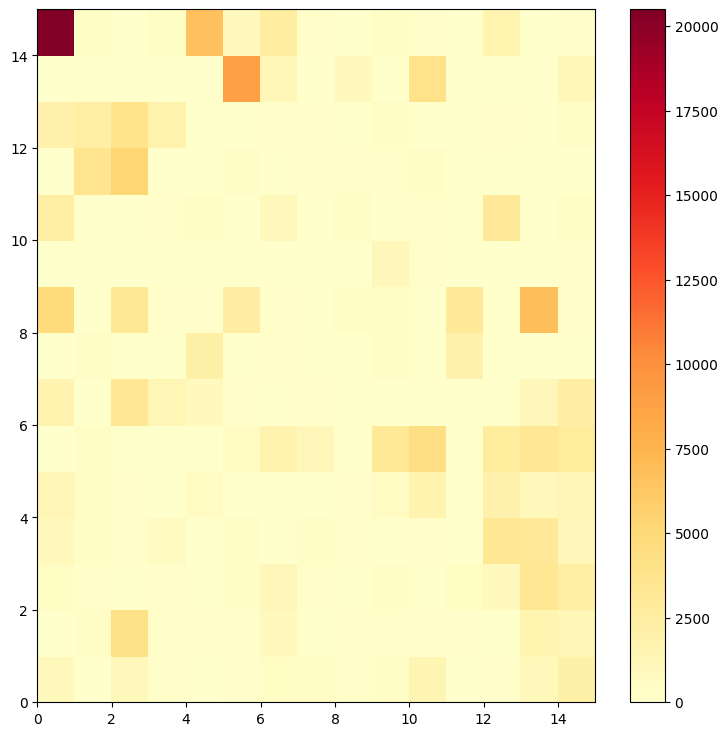

CPU times: user 15.3 s, sys: 1.61 s, total: 17 s
Wall time: 14.3 s


In [75]:
%%time
# Compute the activation map
frequencies = som.activation_response(data)

# Find the maximum value in the activation map
max_value = np.max(frequencies)

# Calculate the percentage distribution at the densest point
densest_point_percentage = (max_value / len(data)) * 100

# Print the percentage distribution
print(f"Percentage distribution ({int(max_value)}/{len(data)})*100) at the densest point: {densest_point_percentage}%")

# Display the activation map
plt.figure(figsize=(9, 9))
plt.pcolor(frequencies.T,cmap='YlOrRd')
plt.colorbar()
plt.show()

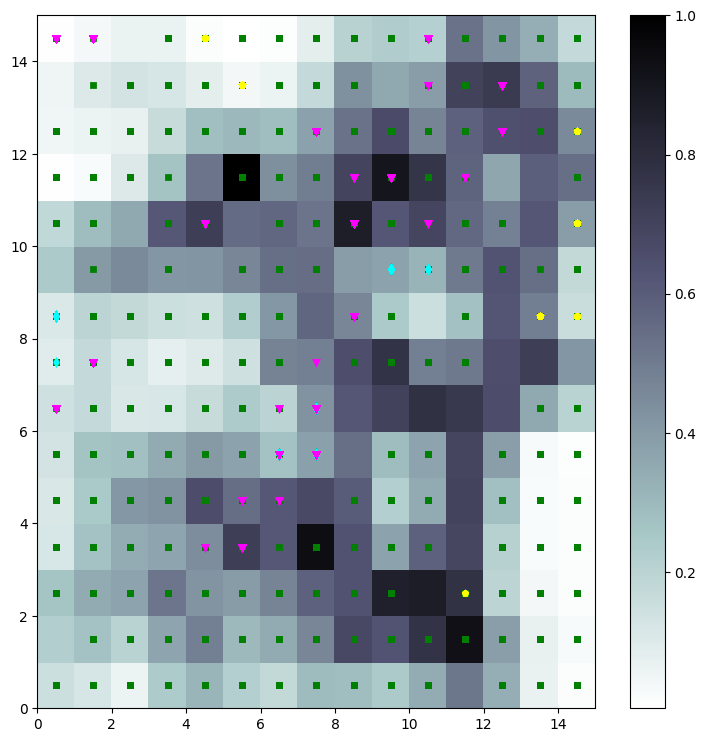

CPU times: user 3min 11s, sys: 3.51 s, total: 3min 15s
Wall time: 3min 14s


In [76]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the processed_friday_dataset
# different colors and markers for each label
markers = ['s', 'v','p','d']
# green='benign' ,magenta='Dos' ,yellow='Bot', cyan='Bruteforce'
colors = ['green', 'magenta','yellow','cyan']
for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor=colors[target[cnt]],
             markeredgecolor=colors[target[cnt]], markersize=3, markeredgewidth=2)

plt.show()